In [ ]:
################### Importing Libraries ######################
import os
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats
import seaborn as sns
url='https://raw.githubusercontent.com/maheesh007/project_ds203/main/train.csv'
response = requests.get(url)

raw_data = response.content.decode('utf-8')
raw_data = raw_data.split("\n")


with open('train.csv', 'w') as file:
  for row in raw_data:
    file.write(row+"\n")
train_df = pd.read_csv('train.csv')
train_df["TotalIncome"]=train_df["ApplicantIncome"]+train_df["CoapplicantIncome"]
train_df["EMI"]=train_df["LoanAmount"]/train_df["Loan_Amount_Term"]
# To make the units equal we multiply with 1000
train_df["Balance_Income"] = train_df["TotalIncome"]-train_df["EMI"]*1000 
#Now we must drop the columns 'ApplicantIncome', 'CoapplicantIncome','LoanAmount' and 'Loan_Amount_Term' from our dataset as these columns will be highly correlated to the columns that we have introduced whereas logistic regression assumes that the variables are not highly correlated
train_df=train_df.drop(["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"],axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Loan_ID         614 non-null    object 
 1   Gender          601 non-null    object 
 2   Married         611 non-null    object 
 3   Dependents      599 non-null    object 
 4   Education       614 non-null    object 
 5   Self_Employed   582 non-null    object 
 6   Credit_History  564 non-null    float64
 7   Property_Area   614 non-null    object 
 8   Loan_Status     614 non-null    object 
 9   TotalIncome     614 non-null    float64
 10  EMI             578 non-null    float64
 11  Balance_Income  578 non-null    float64
dtypes: float64(4), object(8)
memory usage: 57.7+ KB


#Logistic Regression

In [ ]:
train_df = train_df.drop(columns=['Loan_ID']) ## Dropping Loan ID

In [ ]:
#### Encoding categrical Features: ##########
train_df_encoded = pd.get_dummies(train_df,drop_first=True)
train_df_encoded.head()

,Credit_History,TotalIncome,EMI,Balance_Income,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,1.0,5849.0,NaN,NaN,1,0,0,0,0,0,0,0,1,1
1,1.0,6091.0,0.355556,5735.444444,1,1,1,0,0,0,0,0,0,0
2,1.0,3000.0,0.183333,2816.666667,1,1,0,0,0,0,1,0,1,1
3,1.0,4941.0,0.333333,4607.666667,1,1,0,0,0,1,0,0,1,1
4,1.0,6000.0,0.391667,5608.333333,1,0,0,0,0,0,0,0,1,1


In [ ]:
########## Split Features and Target Varible ############
X = train_df_encoded.drop(columns='Loan_Status_Y')
y = train_df_encoded['Loan_Status_Y']

################# Splitting into Train -Test Data #######
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,stratify =y,random_state =1)
############### Handling/Imputing Missing values #############
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
imp_train = imp.fit(X_train)
X_train = imp_train.transform(X_train)
X_test_val = imp_train.transform(X_val)

In [ ]:
X.dtypes

Credit_History             float64
TotalIncome                float64
EMI                        float64
Balance_Income             float64
Gender_Male                  uint8
Married_Yes                  uint8
Dependents_1                 uint8
Dependents_2                 uint8
Dependents_3+                uint8
Education_Not Graduate       uint8
Self_Employed_Yes            uint8
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
dtype: object

We will now check how the train and validation accuracy vary with the split ratio

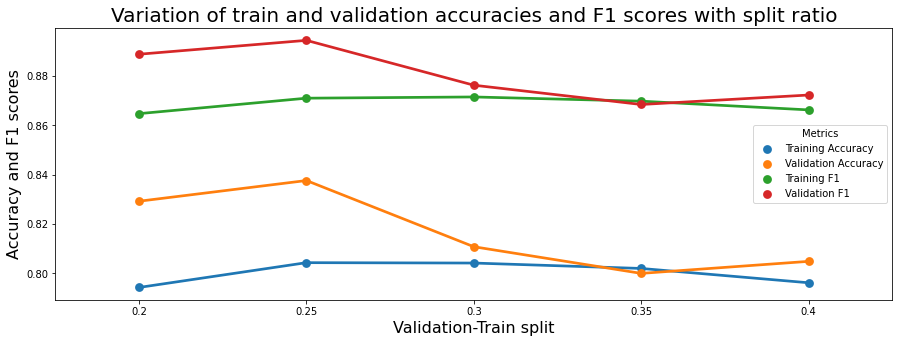

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
thresh=0.6


a_train=[]
f_train=[]
a_val=[]
f_val=[]
split=[0.2,0.25,0.3,0.35,0.4]
for i in split:
  X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=i,stratify =y,random_state =1)
  ############### Handling/Imputing Missing values #############
  from sklearn.impute import SimpleImputer
  imp = SimpleImputer(strategy='mean')
  imp_train = imp.fit(X_train)
  X_train = imp_train.transform(X_train)
  X_val_imp = imp_train.transform(X_val)
  logreg_clf = LogisticRegression(solver='liblinear')
  logreg_clf.fit(X_train,y_train)
    
  y_pred_train_thresh = logreg_clf.predict_proba(X_train)[:,1]
  y_pred_train = (y_pred_train_thresh > thresh).astype(int)

  train_acc = accuracy_score(y_train,y_pred_train)
  train_f1 = f1_score(y_train,y_pred_train)
    
  y_pred_val_thresh = logreg_clf.predict_proba(X_val_imp)[:,1]
  y_pred_val = (y_pred_val_thresh > thresh).astype(int) 
    
  val_acc = accuracy_score(y_val,y_pred_val)
  val_f1 = f1_score(y_val,y_pred_val)
  a_train.append(train_acc)
  f_train.append(train_f1)
  a_val.append(val_acc)
  f_val.append(val_f1)  
Split_logreg = {"Training Accuracy": a_train, "Validation Accuracy": a_val, "Training F1": f_train, "Validation F1":f_val, "Split": split }
Split_logreg_df = pd.DataFrame.from_dict(Split_logreg)

plot_df = Split_logreg_df.melt('Split',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Split", y="Values",hue="Metrics", data=plot_df,ax=ax)
plt.xlabel('Validation-Train split',fontsize=16)
plt.ylabel('Accuracy and F1 scores',fontsize=16)
plt.title('Variation of train and validation accuracies and F1 scores with split ratio',fontsize=20)
plt.show()

We can see that when the train accuracy remains almost constant on varying the split ratio between train and validation set
Best validation accuracy is obtained when the split ratio is 0.25 ,i.e, 25% validation data and 75% train data
>Therefore, we will split the train dataset into 25% validation and 75% train data for further analysis

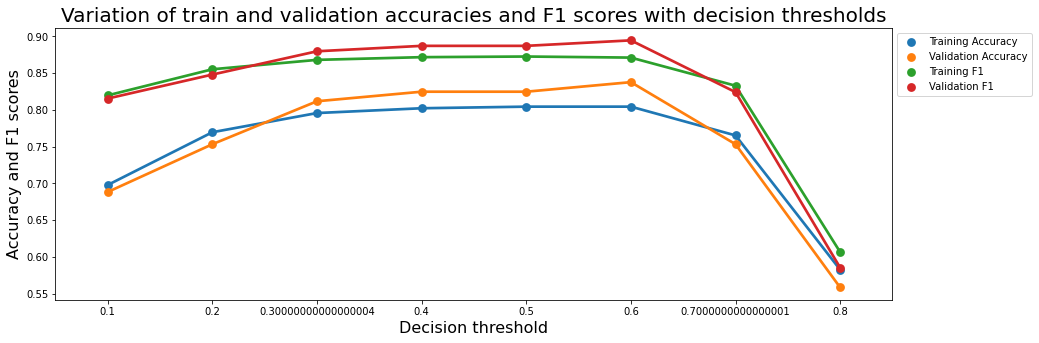

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict


X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,stratify =y,random_state =1)
############### Handling/Imputing Missing values #############
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
imp_train = imp.fit(X_train)
X_train = imp_train.transform(X_train)
X_val_imp = imp_train.transform(X_val)
logreg_clf = LogisticRegression(solver='liblinear')
logreg_clf.fit(X_train,y_train)

train_accuracies = []
train_f1_scores = []
val_accuracies = []
val_f1_scores = []
thresholds = []

for thresh in np.arange(0.1,0.9,0.1): ## Sweeping from threshold of 0.1 to 0.9
    logreg_clf = LogisticRegression(solver='liblinear')
    logreg_clf.fit(X_train,y_train)
    
    y_p_train_thresh = logreg_clf.predict_proba(X_train)[:,1]
    y_p_train = (y_p_train_thresh > thresh).astype(int)

    train_acc = accuracy_score(y_train,y_p_train)
    train_f1 = f1_score(y_train,y_p_train)
    
    y_p_val_thresh = logreg_clf.predict_proba(X_val_imp)[:,1]
    y_p_val = (y_p_val_thresh > thresh).astype(int) 
    
    val_acc = accuracy_score(y_val,y_p_val)
    val_f1 = f1_score(y_val,y_p_val)
    
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    thresholds.append(thresh)
    
    
Threshold_logreg = {"Training Accuracy": train_accuracies, "Validation Accuracy": val_accuracies, "Training F1": train_f1_scores, "Validation F1":val_f1_scores, "Decision Threshold": thresholds }
Threshold_logreg_df = pd.DataFrame.from_dict(Threshold_logreg)

plot_df = Threshold_logreg_df.melt('Decision Threshold',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Decision Threshold", y="Values",hue="Metrics", data=plot_df,ax=ax)
plt.xlabel('Decision threshold',fontsize=16)
plt.ylabel('Accuracy and F1 scores',fontsize=16)
plt.title('Variation of train and validation accuracies and F1 scores with decision thresholds',fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()


We can see that setting the threshold as 0.6 gives the best validation accuracy as well as f1 score. So we set the threshold to 0.6

In [ ]:
thresh = 0.6 ### Threshold chosen from above Curve
y_p_val_thresh = logreg_clf.predict_proba(X_val_imp)[:,1]
y_p = (y_p_val_thresh > thresh).astype(int) 
a1=accuracy_score(y_val,y_p)
f1=f1_score(y_val,y_p)
from sklearn.metrics import roc_auc_score
auc1=roc_auc_score(y_val, y_p)
print("Validation Accuracy: ",accuracy_score(y_val,y_p))
print("Validation F1 Score: ",f1_score(y_val,y_p))
print("Validation auc Score: ",auc1)
print("Confusion Matrix on validation Data")
pd.crosstab(y_val, y_p, rownames=['Actual'], colnames=['Predicted'], margins=True)

Validation Accuracy:  0.8376623376623377
Validation F1 Score:  0.8945147679324894
Validation auc Score:  0.7395833333333333
Confusion Matrix on validation Data


Predicted,0,1,All
Actual,,,
0,23,25,48
1,0,106,106
All,23,131,154


In [ ]:
from sklearn.metrics import classification_report
print('Classification report \n',classification_report(y_val, y_p))

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.48      0.65        48
           1       0.81      1.00      0.89       106

    accuracy                           0.84       154
   macro avg       0.90      0.74      0.77       154
weighted avg       0.87      0.84      0.82       154



>Now we predict the loan status of our test dataset

In [ ]:
url='https://raw.githubusercontent.com/maheesh007/project_ds203/main/test.csv'
response = requests.get(url)

raw_data = response.content.decode('utf-8')
raw_data = raw_data.split("\n")


with open('test.csv', 'w') as file:
  for row in raw_data:
    file.write(row+"\n")


test_df=pd.read_csv('test.csv')
test_df["TotalIncome"]=test_df["ApplicantIncome"]+test_df["CoapplicantIncome"]
test_df["EMI"]=test_df["LoanAmount"]/test_df["Loan_Amount_Term"]
test_df["Balance_Income"] = test_df["TotalIncome"]-test_df["EMI"]*1000 # To make the units equal we multiply with 1000
test_df=test_df.drop(["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"],axis=1)


test_df = test_df.drop(columns=['Loan_ID']) ## Dropping Loan ID
#### Encoding categrical Features: ##########
test_df_encoded = pd.get_dummies(test_df,drop_first=True)
test_df_encoded.head()

from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
imp_test = imp.fit(test_df_encoded)
test_x = imp_test.transform(test_df_encoded)


thresh = 0.4 ### Threshold chosen from above Curves
y_test_thresh = logreg_clf.predict_proba(test_x)[:,1]
y_p = (y_test_thresh > thresh).astype(int)
test_df['Loan_Status_Prediction']=y_p



In [ ]:
test_df.head(10)

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,TotalIncome,EMI,Balance_Income,Loan_Status_Prediction
0,Male,Yes,0,Graduate,No,1.0,Urban,5720,0.305556,5414.444444,1
1,Male,Yes,1,Graduate,No,1.0,Urban,4576,0.350000,4226.000000,1
2,Male,Yes,2,Graduate,No,1.0,Urban,6800,0.577778,6222.222222,1
3,Male,Yes,2,Graduate,No,NaN,Urban,4886,0.277778,4608.222222,1
4,Male,No,0,Not Graduate,No,1.0,Urban,3276,0.216667,3059.333333,1
5,Male,Yes,0,Not Graduate,Yes,1.0,Urban,5587,0.422222,5164.777778,1
6,Female,No,1,Not Graduate,No,1.0,Semiurban,2226,0.163889,2062.111111,1
7,Male,Yes,2,Not Graduate,No,0.0,Rural,3881,0.408333,3472.666667,0
8,Male,Yes,2,Graduate,NaN,1.0,Urban,13633,1.166667,12466.333333,1
9,Male,No,0,Not Graduate,No,1.0,Semiurban,4800,0.341667,4458.333333,1


<Figure size 432x288 with 0 Axes>

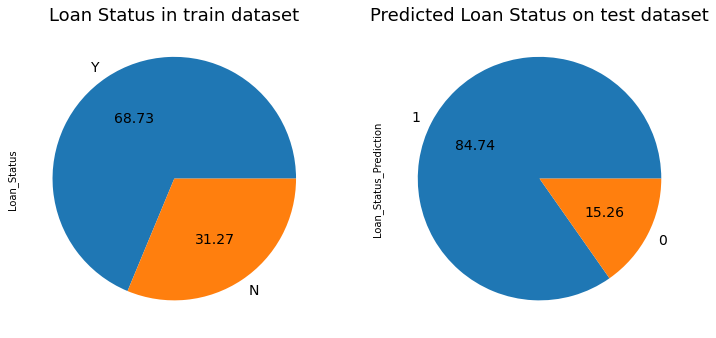

In [ ]:
plt.figure(1)
fig = plt.subplots(figsize=(12,6));
plt.subplot(121);
train_df['Loan_Status'].value_counts().plot.pie(autopct='%.2f',fontsize=14);
plt.title('Loan Status in train dataset',fontsize=18);
plt.subplot(122);
test_df['Loan_Status_Prediction'].value_counts().plot.pie(autopct='%.2f',fontsize=14);
plt.title('Predicted Loan Status on test dataset',fontsize=18)
plt.show()

#Random Forest Classifier

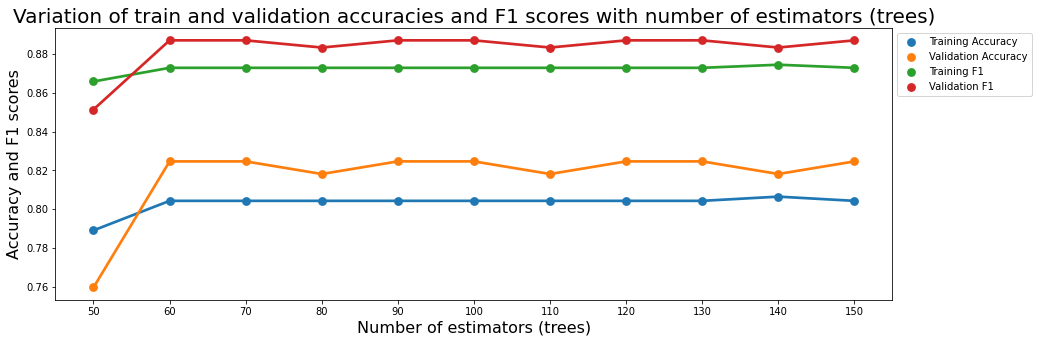

In [ ]:
from sklearn.ensemble import RandomForestClassifier
n_est=[50,60,70,80,90,100,110,120,130,140,150]
train_acc_rf=[]
train_f1_rf=[]
val_acc_rf=[]
val_f1_rf=[]
estimators=[]
for n in n_est:
  rf_clf = RandomForestClassifier(n_estimators=n,max_depth=3,min_samples_leaf = 10)
  rf_clf.fit(X_train,y_train)
  y_pred_train_rf = rf_clf.predict(X_train)
  y_pred_val_rf = rf_clf.predict(X_val_imp)

  train_acc = accuracy_score(y_train,y_pred_train_rf)
  train_f1 = f1_score(y_train,y_pred_train_rf)
  val_acc = accuracy_score(y_val,y_pred_val_rf)
  val_f1 = f1_score(y_val,y_pred_val_rf)
    
  train_acc_rf.append(train_acc)
  train_f1_rf.append(train_f1)
  val_acc_rf.append(val_acc)
  val_f1_rf.append(val_f1)
  estimators.append(n)

Estimators_rf = {"Training Accuracy": train_acc_rf, "Validation Accuracy": val_acc_rf, "Training F1": train_f1_rf, "Validation F1":val_f1_rf, "Number of estimators": estimators }
Estimators_rf_df = pd.DataFrame.from_dict(Estimators_rf)

plot_df = Estimators_rf_df.melt('Number of estimators',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Number of estimators", y="Values",hue="Metrics", data=plot_df,ax=ax)
plt.xlabel('Number of estimators (trees)',fontsize=16)
plt.ylabel('Accuracy and F1 scores',fontsize=16)
plt.title('Variation of train and validation accuracies and F1 scores with number of estimators (trees)',fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()


After 100 estimators, the validation accuracies are almost the same. Also validation accuracy is highest in case of 100 estimators (trees), so we use 100 estimators.
The above plot may vary after each run but setting the number of estimators to 100 generally gives good result

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_train,y_train)
y_pred_train_rf = rf_clf.predict(X_train)
y_pred_val_rf = rf_clf.predict(X_val_imp)
a2=accuracy_score(y_val,y_pred_val_rf)
f2=f1_score(y_val,y_pred_val_rf)
auc2=roc_auc_score(y_val, y_pred_val_rf)
print("Validation Accuracy: ",accuracy_score(y_val,y_pred_val_rf))
print("Validation F1 Score: ",f1_score(y_val,y_pred_val_rf))
print("Validation AUC Score: ",auc2)
print("Confusion Matrix on Validation Data")
pd.crosstab(y_val, y_pred_val_rf, rownames=['True'], colnames=['Predicted'], margins=True)

Validation Accuracy:  0.8181818181818182
Validation F1 Score:  0.8833333333333333
Validation AUC Score:  0.7083333333333333
Confusion Matrix on Validation Data


Predicted,0,1,All
True,,,
0,20,28,48
1,0,106,106
All,20,134,154


In [ ]:
from sklearn.metrics import classification_report
print('Classification report \n',classification_report(y_val, y_pred_val_rf))

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.42      0.59        48
           1       0.79      1.00      0.88       106

    accuracy                           0.82       154
   macro avg       0.90      0.71      0.74       154
weighted avg       0.86      0.82      0.79       154



Now we apply our random forest classifier model on the test dataset.

<Figure size 432x288 with 0 Axes>

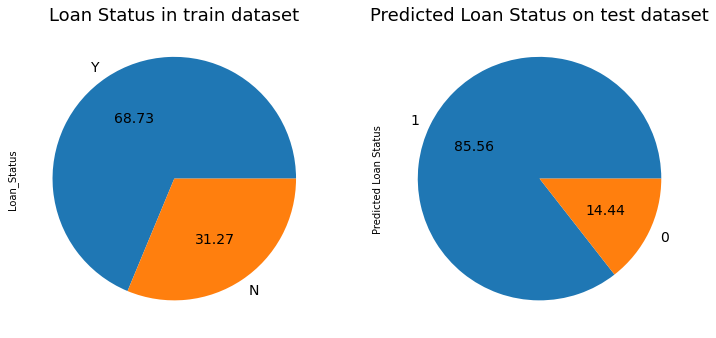

In [ ]:
test_rf=pd.read_csv('test.csv')
test_rf["TotalIncome"]=test_rf["ApplicantIncome"]+test_rf["CoapplicantIncome"]
test_rf["EMI"]=test_rf["LoanAmount"]/test_rf["Loan_Amount_Term"]
test_rf["Balance_Income"] = test_rf["TotalIncome"]-test_rf["EMI"]*1000 # To make the units equal we multiply with 1000
test_rf=test_rf.drop(["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"],axis=1)


test_rf = test_rf.drop(columns=['Loan_ID']) ## Dropping Loan ID
#### Encoding categrical Features: ##########
test_rf_encoded = pd.get_dummies(test_rf,drop_first=True)
test_rf_encoded.head()

from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
imp_test = imp.fit(test_rf_encoded)
test_rf_x = imp_test.transform(test_rf_encoded)
y_pred_test = rf_clf.predict(test_rf_x)
test_rf['Predicted Loan Status']=y_pred_test
plt.figure(1);
fig = plt.subplots(figsize=(12,6));
plt.subplot(121);
train_df['Loan_Status'].value_counts().plot.pie(autopct='%.2f',fontsize=14);
plt.title('Loan Status in train dataset',fontsize=18);
plt.subplot(122);
test_rf['Predicted Loan Status'].value_counts().plot.pie(autopct='%.2f',fontsize=14);
plt.title('Predicted Loan Status on test dataset',fontsize=18)
plt.show()

#Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score


tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  1.0
Training Data F1 Score  1.0
Validation Mean F1 Score:  0.67503015896945
Validation Mean Accuracy:  0.6956521739130435


The train accuracy is 1 while the validation accuracy is around 0.7. This clearly indicates that there is overfitting. So we try different maximum depths for our decision tree model.

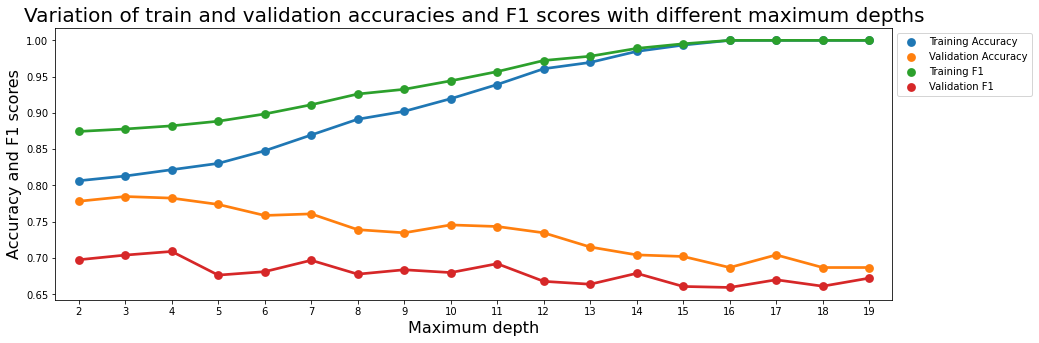

In [ ]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
tree_depths = []

for depth in range(2,20):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    tree_depths.append(depth)
    

Tuning_Max_depth = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Max_Depth": tree_depths }
Tuning_Max_depth_df = pd.DataFrame.from_dict(Tuning_Max_depth)

plot_df = Tuning_Max_depth_df.melt('Max_Depth',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Max_Depth", y="Values",hue="Metrics", data=plot_df,ax=ax)
plt.xlabel('Maximum depth',fontsize=16)
plt.ylabel('Accuracy and F1 scores',fontsize=16)
plt.title('Variation of train and validation accuracies and F1 scores with different maximum depths',fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()


We can clearly see that after maximum depth of three, the train accuracy increases but the validation accuracy decreases so overfitting takes place. Therefore, we set the maximum depth for our decision tree model to 3.

In [ ]:
from sklearn.metrics import confusion_matrix
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_val_imp)
a3=accuracy_score(y_val,y_pred)
f3=f1_score(y_val,y_pred)
auc3=roc_auc_score(y_val,y_pred)
print("Validation Accuracy: ",accuracy_score(y_val,y_pred))
print("Validation F1 Score: ",f1_score(y_val,y_pred))
print("Validation AUC Score: ",auc3)
print("Confusion Matrix on Validation Data")
pd.crosstab(y_val, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Validation Accuracy:  0.8441558441558441
Validation F1 Score:  0.8983050847457628
Validation AUC Score:  0.75
Confusion Matrix on Validation Data


Predicted,0,1,All
True,,,
0,24,24,48
1,0,106,106
All,24,130,154


In [ ]:
from sklearn.metrics import classification_report
print('Classification report \n',classification_report(y_val, y_pred))

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.50      0.67        48
           1       0.82      1.00      0.90       106

    accuracy                           0.84       154
   macro avg       0.91      0.75      0.78       154
weighted avg       0.87      0.84      0.83       154



Now we apply our decision tree model on the test dataset.

<Figure size 432x288 with 0 Axes>

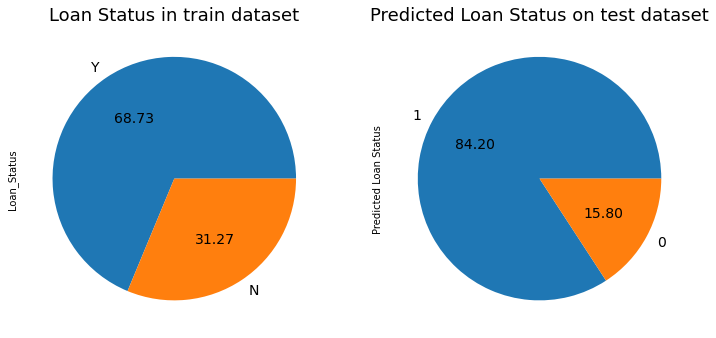

In [ ]:
test_dt=pd.read_csv('test.csv')
test_dt["TotalIncome"]=test_dt["ApplicantIncome"]+test_dt["CoapplicantIncome"]
test_dt["EMI"]=test_dt["LoanAmount"]/test_dt["Loan_Amount_Term"]
test_dt["Balance_Income"] = test_dt["TotalIncome"]-test_dt["EMI"]*1000 # To make the units equal we multiply with 1000
test_dt=test_dt.drop(["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"],axis=1)

test_dt = test_dt.drop(columns=['Loan_ID']) ## Dropping Loan ID
#### Encoding categrical Features: ##########
test_dt_encoded = pd.get_dummies(test_dt,drop_first=True)
test_dt_encoded.head()

from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
imp_test = imp.fit(test_dt_encoded)
test_dt_x = imp_test.transform(test_dt_encoded)
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_train,y_train)
y_pred_test_dt = tree_clf.predict(test_dt_x)
test_dt['Predicted Loan Status']=y_pred_test_dt
plt.figure(1);
fig = plt.subplots(figsize=(12,6));
plt.subplot(121);
train_df['Loan_Status'].value_counts().plot.pie(autopct='%.2f',fontsize=14);
plt.title('Loan Status in train dataset',fontsize=18);
plt.subplot(122);
test_dt['Predicted Loan Status'].value_counts().plot.pie(autopct='%.2f',fontsize=14);
plt.title('Predicted Loan Status on test dataset',fontsize=18)
plt.show()

#Comparing the models

The f1 score of different models are: 
Logistic Regression Model: 0.8945147679324894 
Random Forest Model: 0.8833333333333333 
Decision Tree Model: 0.8983050847457628


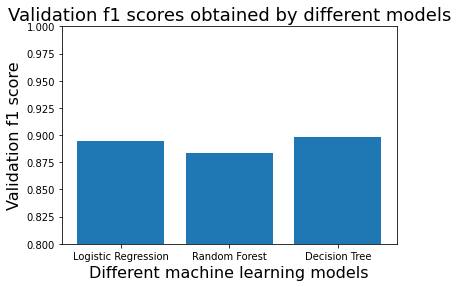

In [ ]:

from google.colab import files
accuracy=[a1*100,a2*100,a3*100]
f1_score_models=[f1,f2,f3]
mod=['Logistic Regression','Random Forest','Decision Tree']
print('The f1 score of different models are: \nLogistic Regression Model:',f1,'\nRandom Forest Model:',f2,'\nDecision Tree Model:',f3)
plt.bar(mod,f1_score_models)
plt.ylim(0.80,1)
plt.title('Validation f1 scores obtained by different models',fontsize=18)
plt.xlabel('Different machine learning models',fontsize=16)
plt.ylabel('Validation f1 score',fontsize=16)
#plt.savefig('accuracy.png')
#files.download('accuracy.png')
plt.show()

>As we can see, Decision Tree model performs slightly better than Logistic Regression and Random Forest Classifier

#Importance of each feature

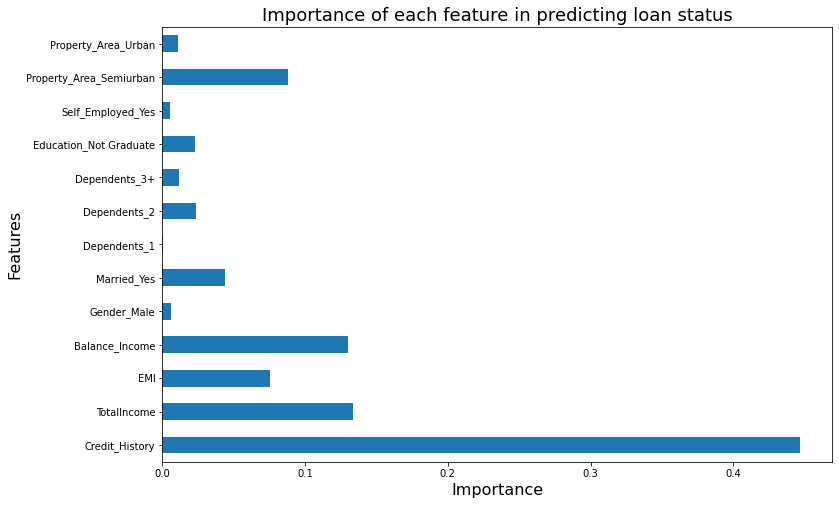

In [ ]:
from google.colab import files
importance = pd.Series(rf_clf.feature_importances_,index=X.columns)
importance.plot(kind='barh', figsize=(12,8))
plt.title('Importance of each feature in predicting loan status',fontsize=18)
plt.ylabel('Features',fontsize=16)
plt.xlabel('Importance',fontsize=16)
#plt.savefig('fig2.png')
#files.download('fig2.png')
plt.show()

From the above bar graph it can be concluded that the 'Credit_History' column is the most important one that helps in predicting the loan status. Also, 'TotalIncome', 'Balance_Income' and 'EMI' columns that we introduced improved the performance of our models.  